In [1]:
# Import das Bibliotecas
from dotenv import load_dotenv
import psycopg
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Executa a função para carregar as variáveis do arquivo .env no ambiente
load_dotenv()

True

In [3]:
# Conexão com o banco de dados
def get_db_connection():
    """Cria e retorna uma conexão com o banco de dados."""
    try:
        conn = psycopg.connect(
            host="localhost",
            dbname=os.getenv("DB_NAME"),
            user=os.getenv("DB_USER"),
            password=os.getenv("DB_PASSWORD"),
            port=os.getenv("DB_PORT")
        )
        return conn
    except Exception as e:
        print(f"Erro ao conectar ao banco de dados: {e}")
        raise e

In [4]:
# Função para converter os números para nomes dos meses
def converter_meses_para_portugues(df, coluna_mes='month'):
    """
    Converte uma coluna numérica de meses (1-12) para nomes em português.
    
    Args:
        df: DataFrame pandas.
        coluna_mes: Nome da coluna com os números dos meses.
    
    Returns:
        DataFrame com a coluna modificada e ordenada corretamente.
    """
    # Mapeamento número -> nome do mês
    meses_pt = {
        1: 'Janeiro',
        2: 'Fevereiro',
        3: 'Março',
        4: 'Abril',
        5: 'Maio',
        6: 'Junho',
        7: 'Julho',
        8: 'Agosto',
        9: 'Setembro',
        10: 'Outubro',
        11: 'Novembro',
        12: 'Dezembro'
    }
    
    # Converte os números para nomes
    df[coluna_mes] = df[coluna_mes].map(meses_pt)
    
    # Garante a ordem cronológica
    ordem_meses = list(meses_pt.values())
    df[coluna_mes] = pd.Categorical(
        df[coluna_mes],
        categories=ordem_meses,
        ordered=True
    )
    
    return df.sort_values(coluna_mes)

In [5]:
def execute_query(query, conn, cursor, return_df = True):
    conn.rollback() # Reinicia a transação (caso tenha alguma transação que tenha dado errado)

    cursor.execute(query)

    # Pegando os dados da consulta
    result = cursor.fetchall()

    # Pegando os nomes das colunas
    columns = cursor.description

    # Colocando o nome das colunas 
    df = [{columns[index][0]: column for index, column in enumerate(value)} for value in result]

    # Transformando de DataFrame para fazer o gráfico
    return pd.DataFrame(df)

In [6]:
# Estabelecendo a conexão
conn = get_db_connection()

# Estabelecendo o cursor para executar consultas
cursor = conn.cursor()

* Série Temporal de Internações:
    - Gráfico de linha com o `case_count` ao longo do tempo `notification_date_id`

In [7]:

query = 'SELECT hc.case_count, hc.notification_date_id, dt.month ' \
        ' FROM gold.fact_health_cases AS hc' \
        ' INNER JOIN gold.dim_date AS dt ON hc.notification_date_id = dt.date_id' 

df = execute_query(query, conn, cursor, True)

In [8]:
df = df.sort_values(by='month')

df = converter_meses_para_portugues(df)

df_agrupado = df.groupby('month', as_index=False)['case_count'].sum()

/tmp/ipykernel_28175/3894488769.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agrupado = df.groupby('month', as_index=False)['case_count'].sum()


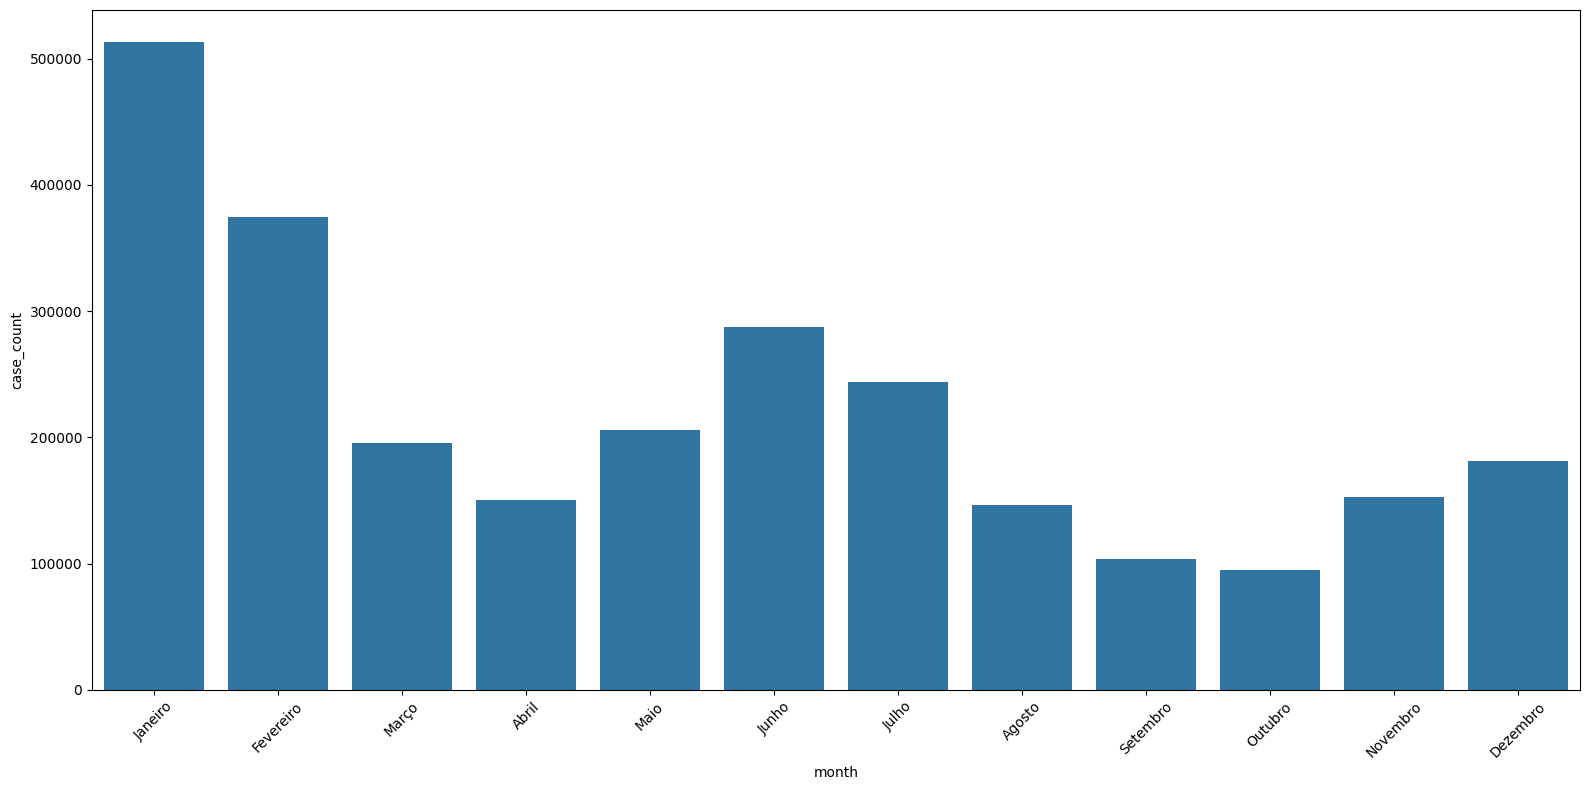

In [9]:
# Gráficos com número de casos por mês
plt.subplots(figsize=(16,8))

sns.barplot(data=df_agrupado, x='month', y='case_count', errorbar=None)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

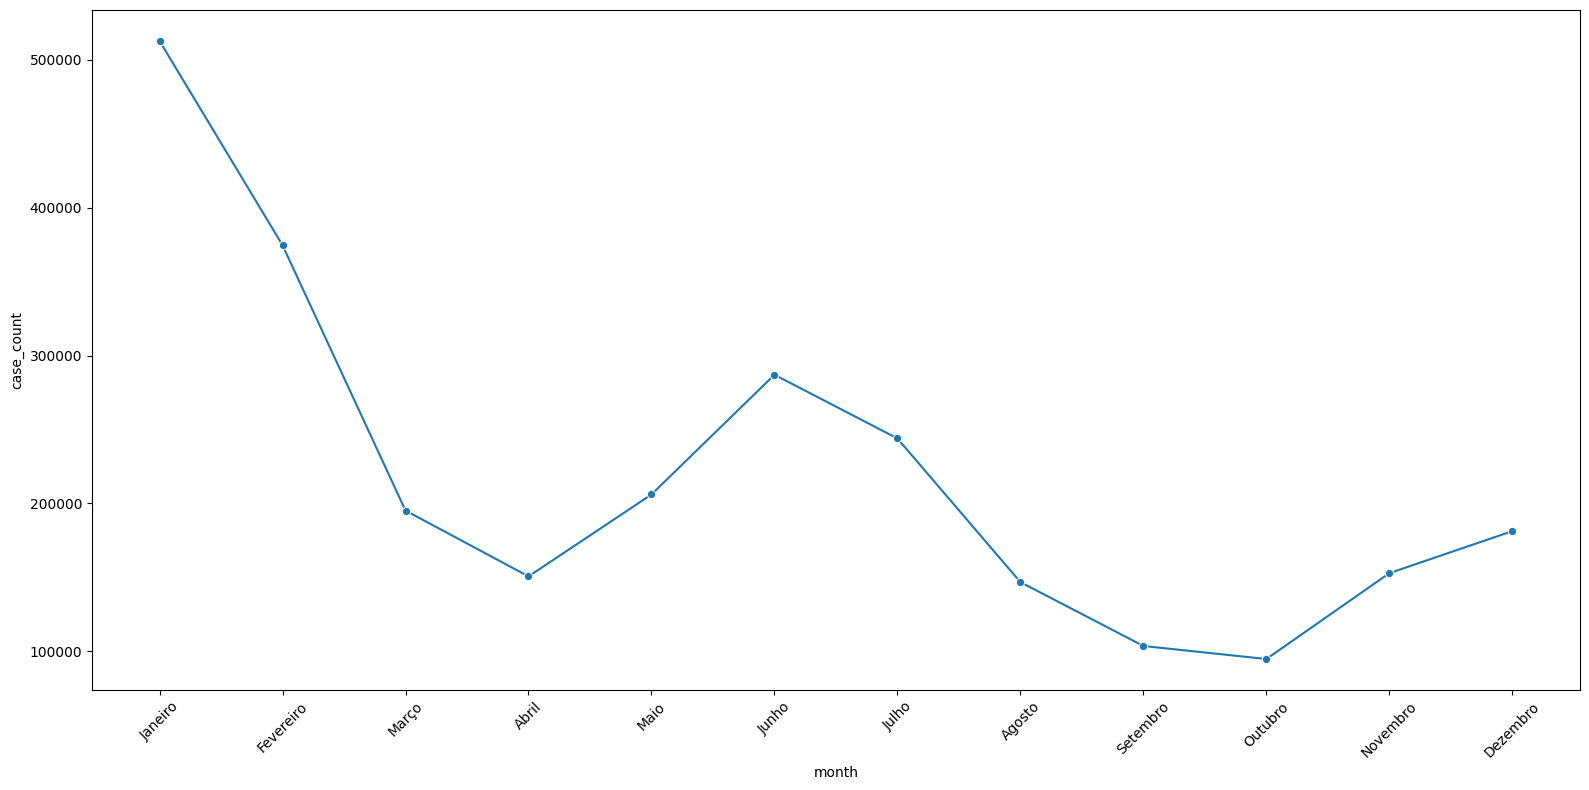

In [10]:
plt.subplots(figsize=(16,8))

sns.lineplot(data=df_agrupado, x='month', y='case_count', marker='o', errorbar=None)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Análise dos Fatores de Risco

* Gráfico de barras mostrando a prevalência de comorbidades
    - Utilizar `fact_health_cases`:
        - Utilizar coluna `required_icu`
        - Linkar com `dim_risk_factors`

In [11]:
query = '''
        SELECT   
                rf.is_puerpera AS puerpera, 
                rf.has_chronic_cardiovascular_disease AS cardiopatia, 
                rf.has_chronic_hematologic_disease AS hematologia, 
                rf.has_down_syndrome AS sindrome_down, 
                rf.has_chronic_liver_disease AS hepatia, 
                rf.has_asthma AS asma, 
                rf.has_diabetes AS diabetes, 
                rf.has_chronic_neurological_disease AS neurologica, 
                rf.has_other_chronic_pneumopathy AS outra_pneumopatia, 
                rf.has_immunodeficiency AS imunodeficiencia, 
                rf.has_chronic_kidney_disease AS renal, 
                rf.has_obesity AS obesidade, 
                 SUM(hc.case_count) AS numero_total_casos  
         FROM gold.fact_health_cases AS hc 
         INNER JOIN 
               gold.dim_risk_factors AS rf 
         ON rf.risk_factors_id = hc.risk_factors_id 
        WHERE
                hc.required_icu = 'SIM'
        GROUP BY
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
        ORDER BY 
                numero_total_casos DESC 
        '''

df = execute_query(query, conn, cursor, True)

In [12]:
# 1. Transformar o DataFrame para formato longo
df_long = df.melt(id_vars=['numero_total_casos'], 
                  value_vars=['puerpera', 'cardiopatia', 'hematologia', 'sindrome_down',
                             'hepatia', 'asma', 'diabetes', 'neurologica',
                             'outra_pneumopatia', 'imunodeficiencia', 'renal', 'obesidade'],
                  var_name='fator_risco', 
                  value_name='tem_condicao')

# 2. Filtrar apenas casos onde tem_condicao é True/1
df_long = df_long[df_long['tem_condicao'] == 'SIM']

/tmp/ipykernel_28175/4012045251.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_long,


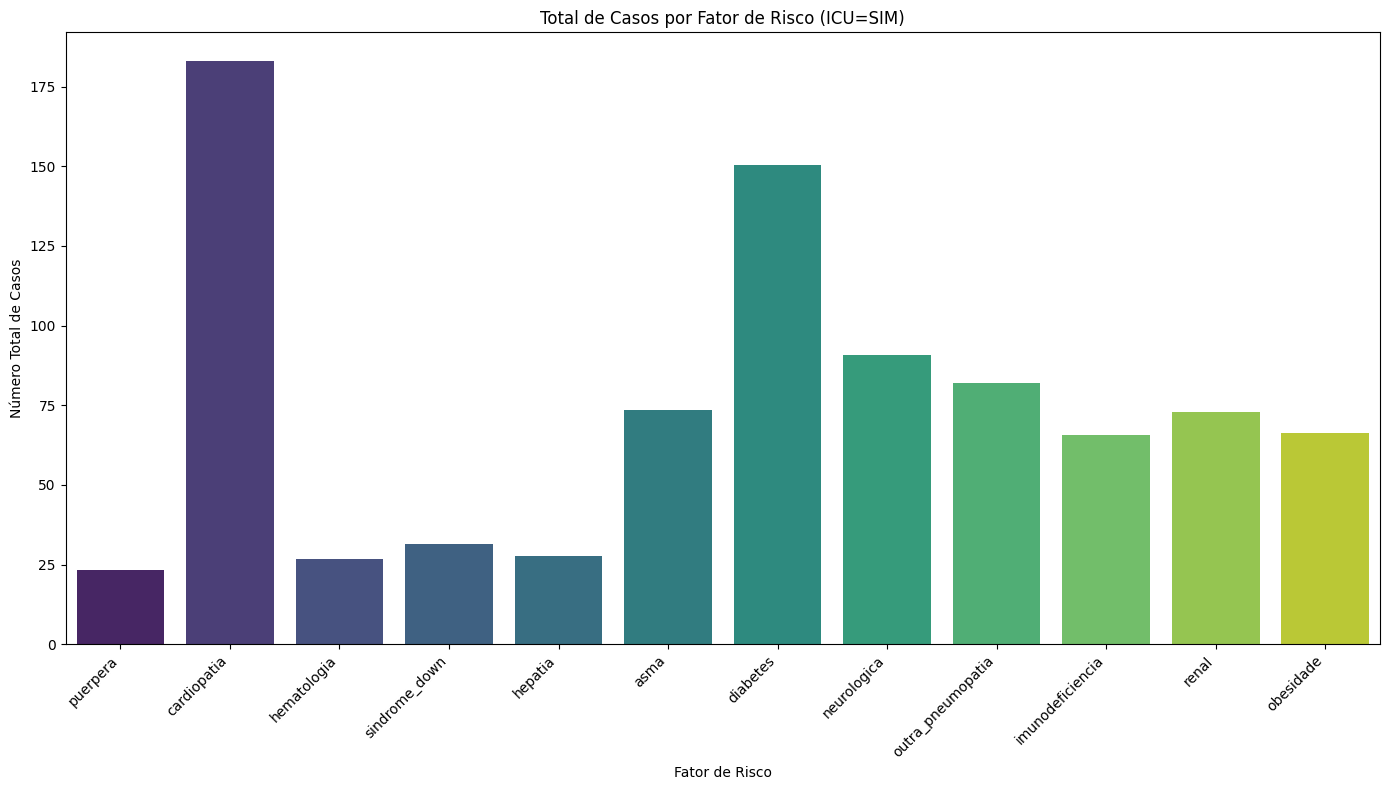

In [13]:
# 3. Criar o gráfico
plt.figure(figsize=(14, 8))
sns.barplot(data=df_long, 
            x='fator_risco', 
            y='numero_total_casos',
            errorbar=None,
            palette='viridis')

# Melhorar a visualização
plt.title('Total de Casos por Fator de Risco (ICU=SIM)')
plt.xlabel('Fator de Risco')
plt.ylabel('Número Total de Casos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_28175/1410486520.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_long,


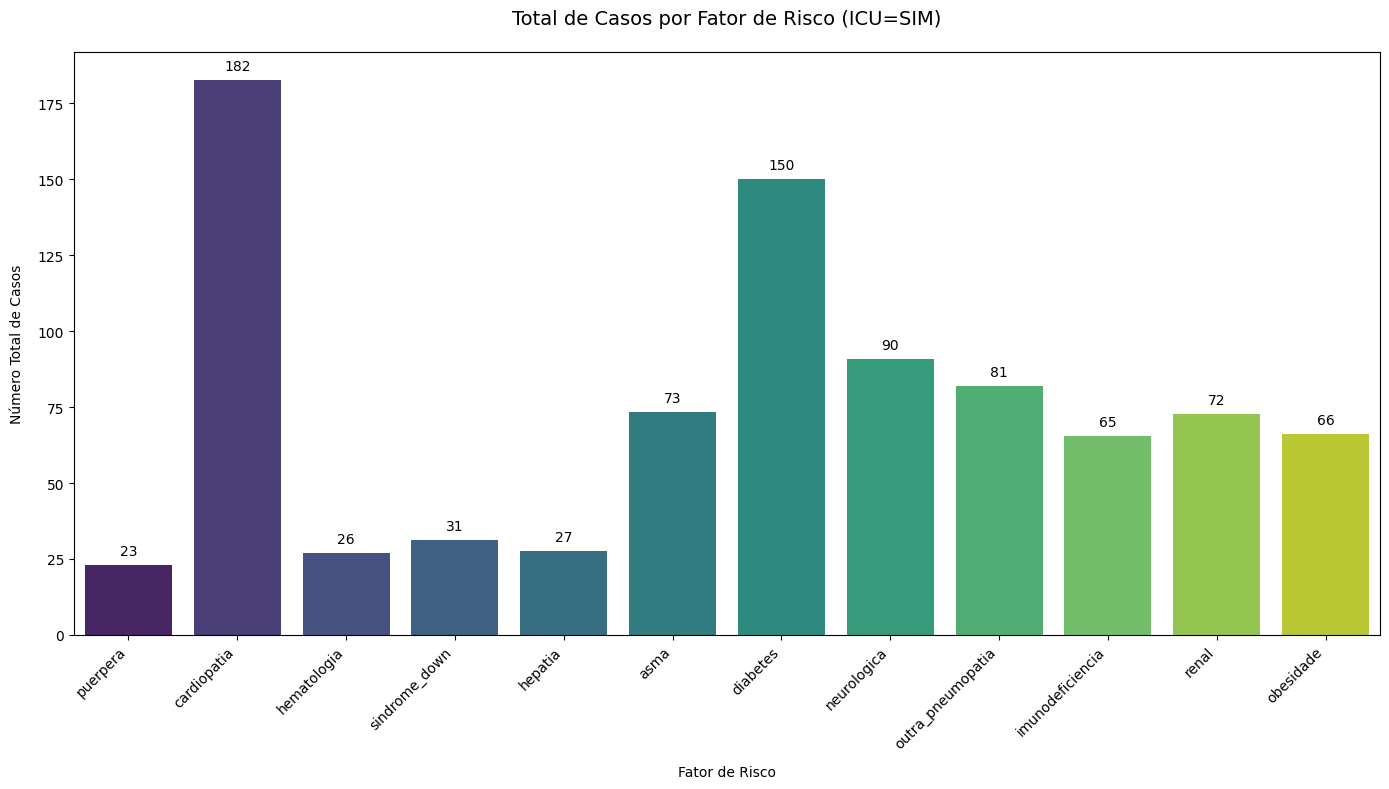

In [14]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_long, 
                x='fator_risco', 
                y='numero_total_casos',
                palette='viridis',
                errorbar=None)

# Adicionando os valores nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # Formata com separador de milhar
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10,
                color='black')

# Melhorando a visualização
plt.title('Total de Casos por Fator de Risco (ICU=SIM)', pad=20, fontsize=14)
plt.xlabel('Fator de Risco', labelpad=10)
plt.ylabel('Número Total de Casos', labelpad=10)
plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/tmp/ipykernel_28175/2235025489.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_long,


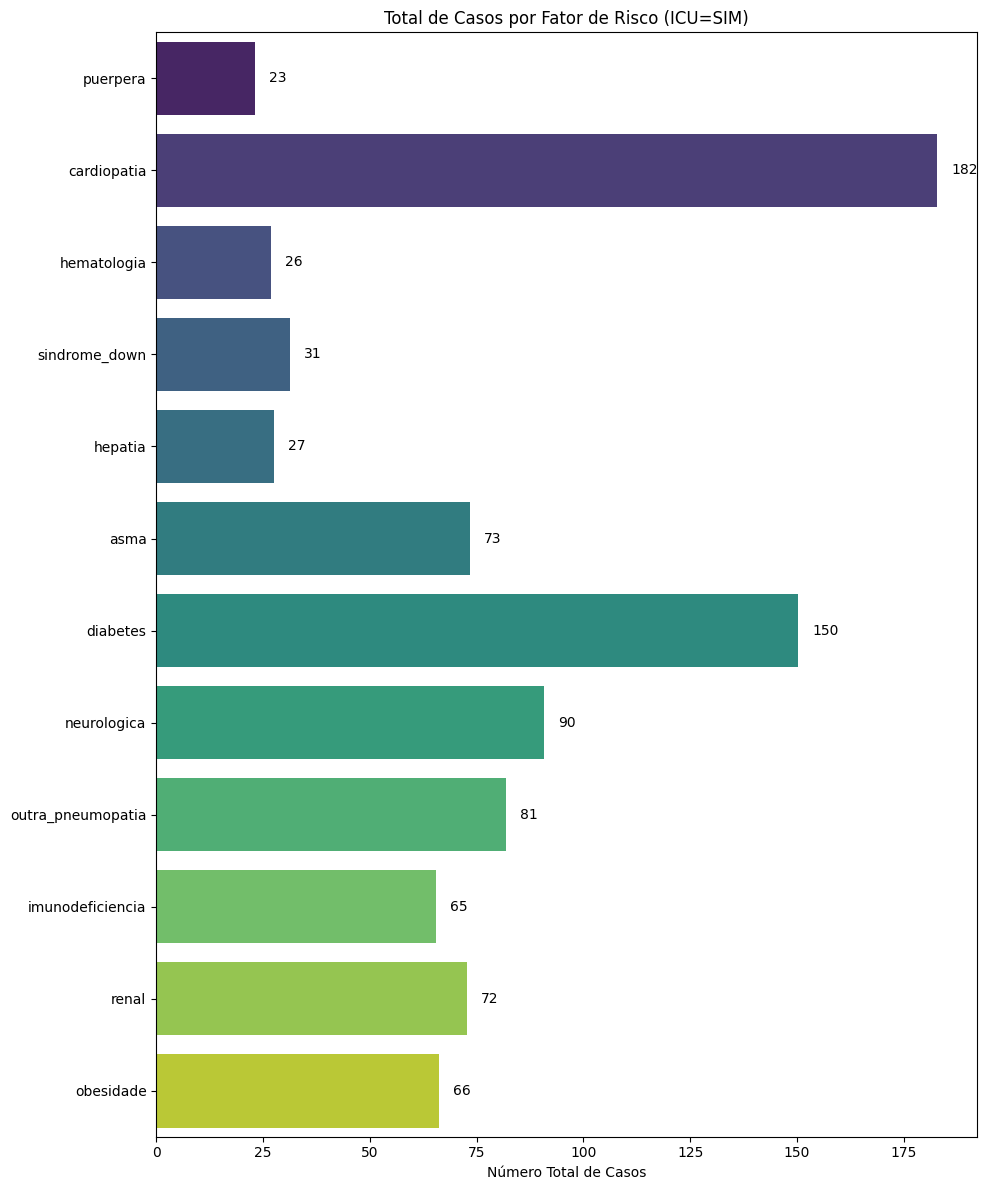

In [15]:
# Opção 1: Gráfico horizontal
plt.figure(figsize=(10, 12))
ax = sns.barplot(data=df_long, 
                y='fator_risco',  # Troca X por Y
                x='numero_total_casos',
                palette='viridis',
                errorbar=None)

# Adiciona os valores (ajustado para horizontal)
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}',
                (p.get_width(), p.get_y() + p.get_height()/2.),
                va='center',
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=10)

plt.title('Total de Casos por Fator de Risco (ICU=SIM)')
plt.xlabel('Número Total de Casos')
plt.ylabel('')
plt.tight_layout()
plt.show()

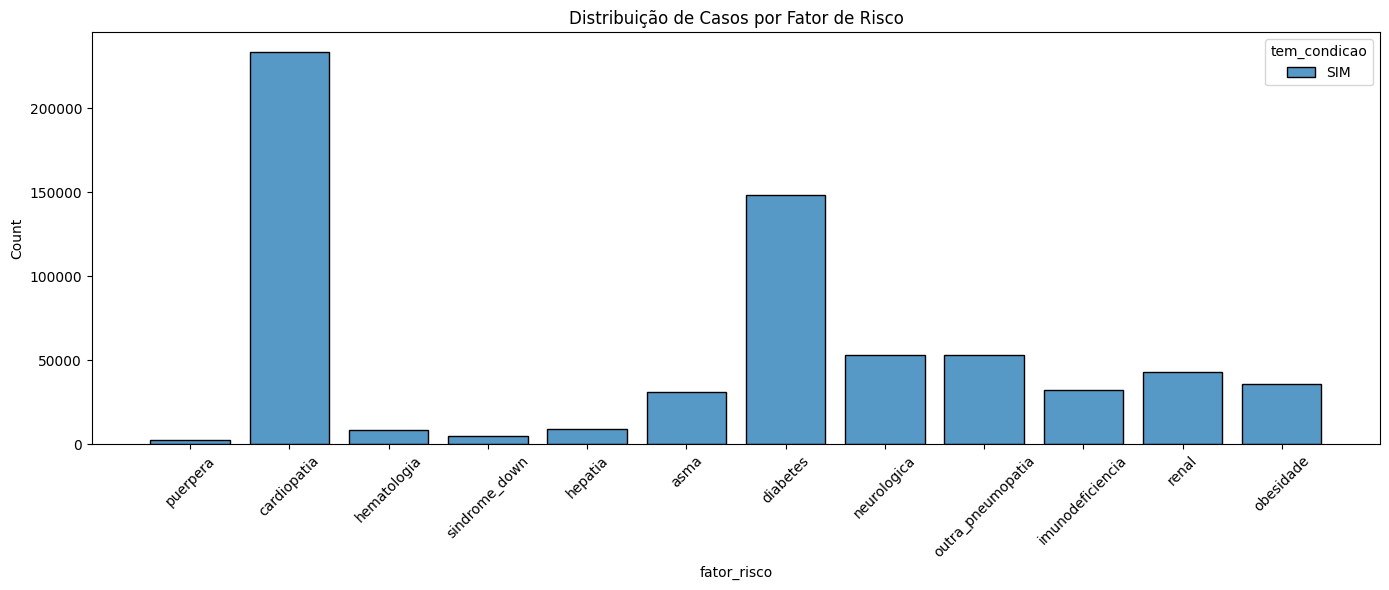

In [16]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df_long, 
             x='fator_risco', 
             weights='numero_total_casos',
             hue='tem_condicao',
             multiple='stack',
             shrink=0.8)

plt.title('Distribuição de Casos por Fator de Risco')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Distribuição Demográfica dos Casos:
    - Distribuição dos casos por `age_group` e `gender`
    - Identificação da dos grupos mais vulneráveis

In [21]:
query = '''
        SELECT 
            pt.gender AS genero,
            pt.age_group AS faixa_etaria,
            SUM(hc.case_count) AS numero_total_casos
        FROM 
            gold.dim_patients AS PT
        INNER JOIN
            gold.fact_health_cases AS hc
        ON
            pt.patient_id = hc.patient_id
        WHERE 
            pt.gender != 'IGNORADO'
        GROUP BY
            1, 2
        ORDER BY
            pt.age_group
'''

df = execute_query(query, conn, cursor, True)

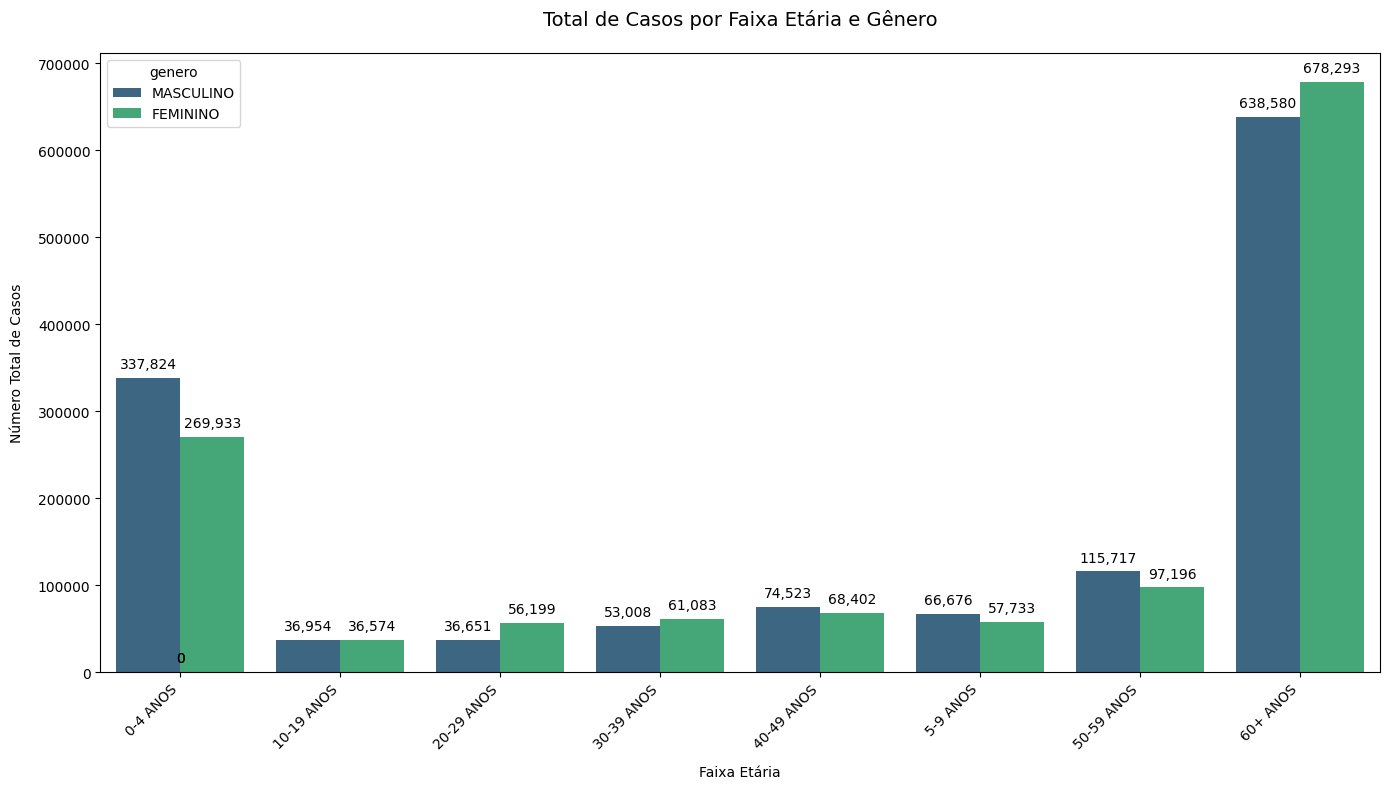

In [24]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df, 
                x='faixa_etaria', 
                y='numero_total_casos',
                palette='viridis',
                hue='genero',
                errorbar=None)

# Adicionando os valores nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # Formata com separador de milhar
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10,
                color='black')

# Melhorando a visualização
plt.title('Total de Casos por Faixa Etária e Gênero', pad=20, fontsize=14)
plt.xlabel('Faixa Etária', labelpad=10)
plt.ylabel('Número Total de Casos', labelpad=10)
plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
query = '''
        SELECT 
            cc.final_classification AS srag,
            cc.case_outcome AS evolucao,
            SUM(hc.case_count) AS numero_total_casos
        FROM
            gold.dim_case_classifications AS cc
        INNER JOIN
            gold.fact_health_cases AS hc
        ON
            cc.case_classification_id = hc.case_classification_id
        GROUP BY
            1, 2
        ORDER BY
            1
'''

df = execute_query(query, conn, cursor, True)

Esse gráfico, talvez seja melhor, aparecer de acordo com o filtro especificado, ele geral fica muita informação

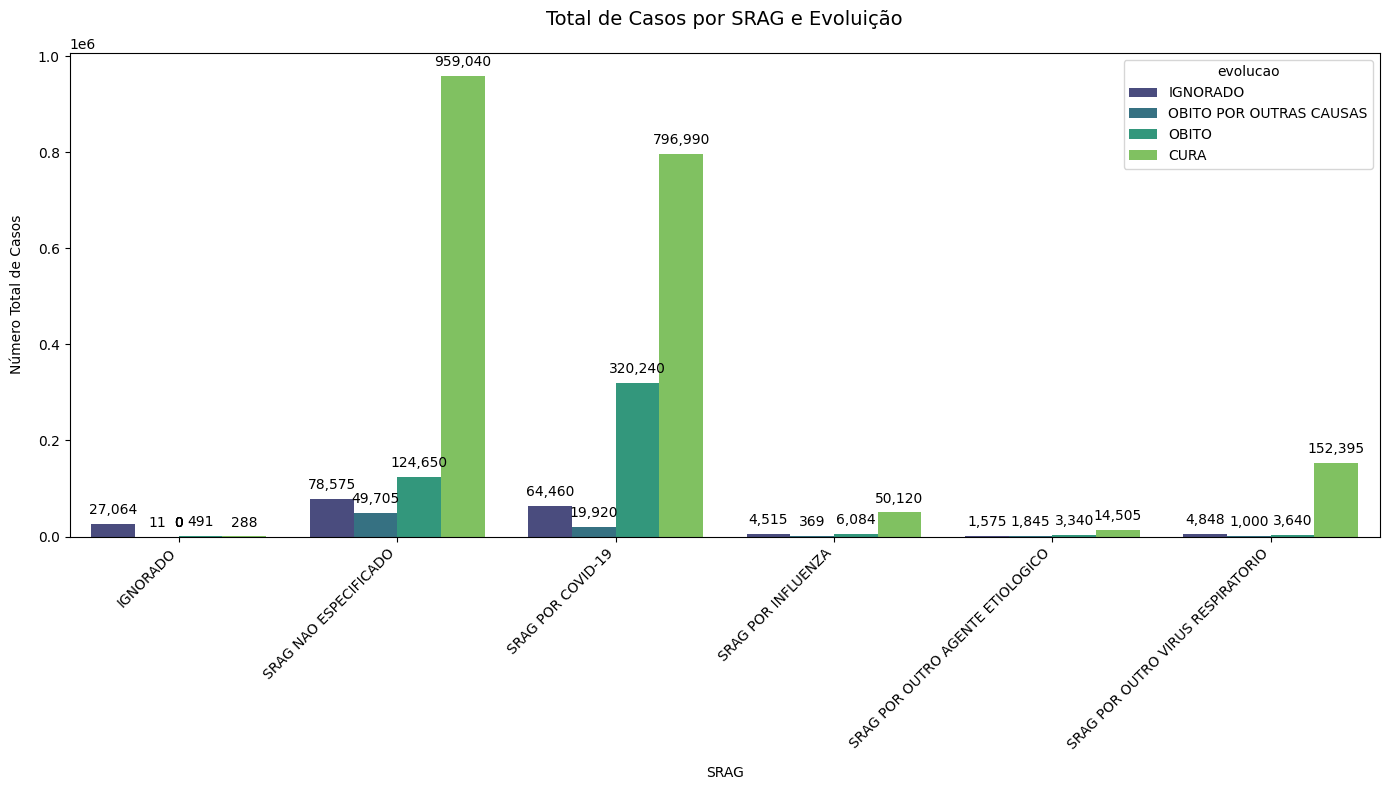

In [34]:
# Gráfico número total de casos por srag e de acordo com a evolução do caso
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df, 
                x='srag', 
                y='numero_total_casos',
                palette='viridis',
                hue='evolucao',
                errorbar=None)

# Adicionando os valores nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # Formata com separador de milhar
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10,
                color='black')

# Melhorando a visualização
plt.title('Total de Casos por SRAG e Evoluição', pad=20, fontsize=14)
plt.xlabel('SRAG', labelpad=10)
plt.ylabel('Número Total de Casos', labelpad=10)
plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

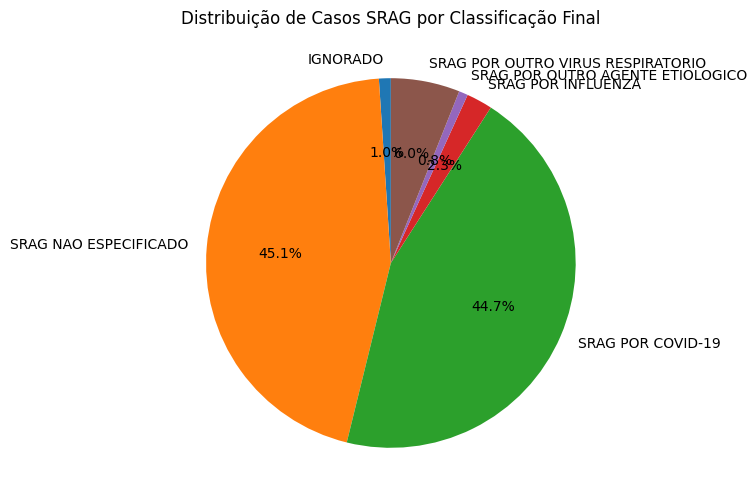

In [35]:
# Agrupar apenas por classificação final
df_srag = df.groupby('srag')['numero_total_casos'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.pie(df_srag['numero_total_casos'], 
        labels=df_srag['srag'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribuição de Casos SRAG por Classificação Final')
plt.show()

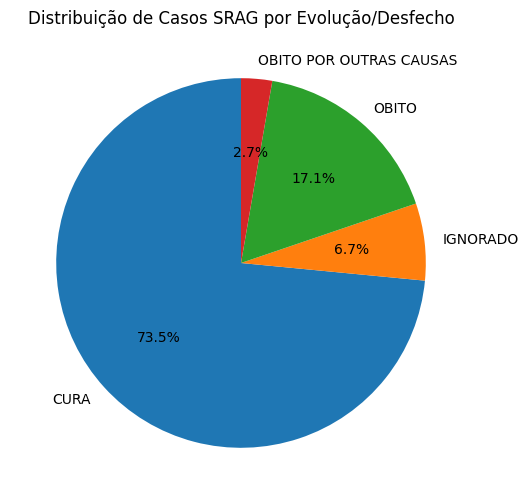

In [37]:
# Agrupar apenas por evolução
df_evol = df.groupby('evolucao')['numero_total_casos'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.pie(df_evol['numero_total_casos'], 
        labels=df_evol['evolucao'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribuição de Casos SRAG por Evolução/Desfecho')
plt.show()